<h1><center><font size="6">工程实践：TalkingData AdTracking EDA</font></center></h1>
<h2><center><font size="5">Light GBM模型的实现</font></center></h2>

# <a id='0'>目录</a>

- <a href='#1'>模型v1介绍</a>  
- <a href='#2'>载入包</a>  
- <a href='#2'>参数设置</a>  
- <a href='#3'>读入数据</a>
- <a href='#6'>特征工程</a>
    - <a href='#62'>派生特征工程</a>
- <a href='#7'>LGBM模型</a>  
    - <a href='#71'>模型定义</a>  
    - <a href='#71'>训练模型并保存模型</a> 
- <a href='#8'>预测及产生submission</a>


# <a id="1">模型v1介绍</a>

- 特征选取：
- 模型参数：
- 模型评估：
- 预测结果：


# <a id="2">载入包</a>

在这里，我们加载库并设置一些参数。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


import lightgbm as lgb
import gc # memory 
from datetime import datetime # train time checking
import pickle

pd.set_option('display.max_columns', 100)

# <a id="3">参数设置</a>

这里我们设置了这个Notebook中使用的大多数参数。



In [2]:
#VALIDATION 使用留出法，评估模型
VALIDATE = True  #validation using train_test_split
VALID_SIZE = 0.10 # simple validation using train_test_split

#CROSS-VALIDATION 使用k折交叉检验，评估模型
VALIDATE_KFOLDS = False #cross-validation using KFolds
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

#使用train.sample作为输入？
SAMPLE = False    #True: use train.sample (100,000 rows) False: use full training set (train)
RANDOM_STATE = 2018

#读取训练集
skiprows = range(1,109903891) #
nrows = 75000000

#取训练集子集
SAMPLE_SIZE = 1 # use a subsample of the train set
output_filename = 'submission_v1.csv'

IS_LOCAL = True


if (IS_LOCAL):
    PATH = '../input/talkingdata_adtracking_fraud_detection/'
else:
    PATH = '../input/'
print(os.listdir(PATH))

['.DS_Store', 'test.csv', 'train_sample.csv', 'test_supplement.csv', 'train.csv', '.ipynb_checkpoints', 'sample_submission.csv']


# <a id="3">读入数据</a>

我们使用** Parameters **部分中设置的选项读取数据。


In [3]:
#设置读取相应列数据类型
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

#设置读入哪些列，降低内存消耗
train_cols = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

#设置读取文件train_sample还是train
if SAMPLE:
    trainset = pd.read_csv(PATH+"train_sample.csv", parse_dates=['click_time'], dtype=dtypes, usecols=train_cols)    
else:
    #使用train时，利用抽样取样，跳行skiprows，取nrows条数据
    trainset = pd.read_csv(PATH+"train.csv", parse_dates=['click_time'], skiprows=skiprows, nrows=nrows,dtype=dtypes, usecols=train_cols)
    trainset = trainset.sample(frac=SAMPLE_SIZE)

# <a id="6">特征工程<a/>

## <a id="62">派生特征的工程</a>

定义用于计算派生特征的多个函数。

In [4]:
#------------------------------------------------------------------------------
#求agg_name特征中的最大值
def show_max_clean(df,gp,agg_name,agg_type,show_max):
#------------------------------------------------------------------------------    
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type,copy=False)
    gc.collect()
    return( df )
    
#------------------------------------------------------------------------------
#每个聚集（特征组合）的个数
def perform_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left', copy=False)
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
#每个group_cols中不同counted的个数
def perform_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Counting unique ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left', copy=False)
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
#计算每个聚集（特征组合）逐渐累加个数，（counted不起作用）
def perform_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
#计算每个聚集（特征组合）中的counted平均值
def perform_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left', copy=False)
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
#计算每个聚集（特征组合）中的counted方差
def perform_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left', copy=False)
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

In [5]:
def prep_data( df ):
    print('Extracting new features...')
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    gc.collect()
    
    # print('the Id of df before function: ',id(df))
    df = perform_countuniq( df, ['ip'], 'channel', 'X0', 'uint8', show_max=False ); gc.collect()
    df = perform_cumcount( df, ['ip', 'device', 'os'], 'app', 'X1', show_max=False ); gc.collect()
    # print('the Id of df after function: ',id(df)) # the same id with 'df' returned
    df = perform_countuniq( df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=False ); gc.collect()
    df = perform_countuniq( df, ['ip'], 'app', 'X3', 'uint16', show_max=False ); gc.collect()
    df = perform_countuniq( df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=False ); gc.collect()
    df = perform_countuniq( df, ['ip'], 'device', 'X5', 'uint16', show_max=False ); gc.collect()
    df = perform_countuniq( df, ['app'], 'channel', 'X6','uint8', show_max=False ); gc.collect()
    df = perform_cumcount( df, ['ip'], 'os', 'X7', show_max=False ); gc.collect()
    df = perform_countuniq( df, ['ip', 'device', 'os'], 'app', 'X8','uint8', show_max=False ); gc.collect()

    df = perform_countuniq( df, ['ip', 'device', 'os'], 'channel', 'A0', show_max=False ); gc.collect()
    df = perform_count( df, ['ip', 'app', 'channel'], 'A1', show_max=False ); gc.collect()
    df = perform_count( df, ['ip', 'device', 'os','app'], 'A2', show_max=False ); gc.collect()
    # ip-device-hour?

    df = perform_count( df, ['ip', 'day', 'hour'], 'ip_tcount','uint16',show_max=False ); gc.collect()
#     df = do_count( df, ['ip', 'hour'], 'ip_tcount2','uint32',show_max=False ); gc.collect()
    df = perform_count( df, ['ip', 'app'], 'ip_app_count','uint32', show_max=False ); gc.collect()
    df = perform_count( df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=False ); gc.collect()
    df = perform_var( df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=False ); gc.collect()
    df = perform_var( df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=False ); gc.collect()
    df = perform_var( df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=False ); gc.collect()
    df = perform_mean( df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=False ); gc.collect()

    print('doing nextClick 2...')
    df['click_time'] = (df['click_time'].astype(np.int64,copy=False) // 10 ** 9).astype(np.int32,copy=False)
    df['nextClick'] = (df.groupby(['ip', 'app', 'device', 'os']).click_time.shift(-1) - df.click_time).astype(np.float32,copy=False)
    df.drop(['click_time','day'], axis=1, inplace=True)
    gc.collect()
    return df
trainset = prep_data(trainset)
trainset.info()
gc.collect()

Extracting new features...
Counting unique  channel  by  ['ip'] ...
Cumulative count by  ['ip', 'device', 'os'] ...
Counting unique  hour  by  ['ip', 'day'] ...
Counting unique  app  by  ['ip'] ...
Counting unique  os  by  ['ip', 'app'] ...
Counting unique  device  by  ['ip'] ...
Counting unique  channel  by  ['app'] ...
Cumulative count by  ['ip'] ...
Counting unique  app  by  ['ip', 'device', 'os'] ...
Counting unique  channel  by  ['ip', 'device', 'os'] ...
Aggregating by  ['ip', 'app', 'channel'] ...
Aggregating by  ['ip', 'device', 'os', 'app'] ...
Aggregating by  ['ip', 'day', 'hour'] ...
Aggregating by  ['ip', 'app'] ...
Aggregating by  ['ip', 'app', 'os'] ...
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
Calculating variance of  day  by  ['ip', 'app', 'channel'] ...
Calculating mean of  hour  by  ['ip', 'app', 'channel'] ...
doing nextClick 2...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500000

14

# <a id="7">模型</a>

## <a id="71">模型的定义</a>

In [6]:
#设置lgb的参数
MAX_ROUNDS = 2000 #lgb iterations
EARLY_STOP = 50  #lgb early stop 
OPT_ROUNDS = 650  #To be adjusted based on best validation rounds
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':'auc',
        'learning_rate': 0.2, # 【consider using 0.1】
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'scale_pos_weight': 200, # because training data is extremely unbalanced
        'num_leaves': 7,  # we should let it be smaller than 2^(max_depth), default=31
        'max_depth': 3,  # -1 means no limit, default=-1
        'min_data_per_leaf': 100,  # alias=min_data_per_leaf , min_data, min_child_samples, default=20
        'max_bin': 100,  # Number of bucketed bin for feature values,default=255
        'subsample': 0.7,  # Subsample ratio of the training instance.default=1.0, alias=bagging_fraction
        'subsample_freq': 1,  # k means will perform bagging at every k iteration, <=0 means no enable,alias=bagging_freq,default=0
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.alias:feature_fraction
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf),default=1e-3,Like min_data_in_leaf, it can be used to deal with over-fitting
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4, # should be equal to REAL cores:http://xgboost.readthedocs.io/en/latest/how_to/external_memory.html
        'verbose': 0
         }

target = 'is_attributed'
predictors = ['nextClick','app','device','os', 'channel', 'hour',
                  'ip_tcount', 'ip_tchan_count', 'ip_app_count',
                  'ip_app_os_count', 'ip_app_os_var',
                  'ip_app_channel_var_day','ip_app_channel_mean_hour',
                  'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
categorical = ['app', 'device', 'os', 'channel', 'hour']


## <a id="72">模型的训练</a>

train size:72500000
valid size:2500000
Training...
Training until validation scores don't improve for 50 rounds.
[10]	valid's auc: 0.861315
[20]	valid's auc: 0.958266
[30]	valid's auc: 0.963042
[40]	valid's auc: 0.965732
[50]	valid's auc: 0.966631
[60]	valid's auc: 0.967517
[70]	valid's auc: 0.967673
[80]	valid's auc: 0.967991
[90]	valid's auc: 0.968181
[100]	valid's auc: 0.968716
[110]	valid's auc: 0.968428
[120]	valid's auc: 0.97032
[130]	valid's auc: 0.970717
[140]	valid's auc: 0.970985
[150]	valid's auc: 0.971218
[160]	valid's auc: 0.971551
[170]	valid's auc: 0.971558
[180]	valid's auc: 0.971583
[190]	valid's auc: 0.971681
[200]	valid's auc: 0.971778
[210]	valid's auc: 0.971874
[220]	valid's auc: 0.971947
[230]	valid's auc: 0.971954
[240]	valid's auc: 0.971961
[250]	valid's auc: 0.971962
[260]	valid's auc: 0.972227
[270]	valid's auc: 0.972326
[280]	valid's auc: 0.972349
[290]	valid's auc: 0.972399
[300]	valid's auc: 0.972404
[310]	valid's auc: 0.972445
[320]	valid's auc: 0.972454
[

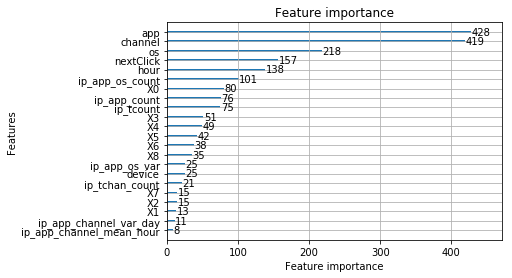

<Figure size 432x288 with 0 Axes>

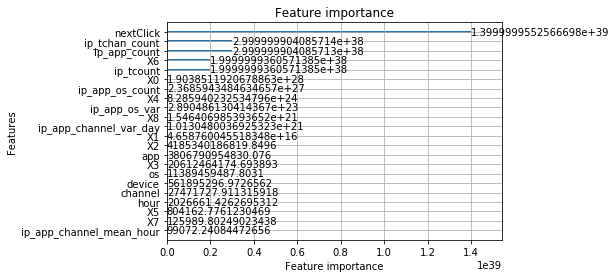

10041

<Figure size 432x288 with 0 Axes>

In [8]:
if VALIDATE:

    #train_df, val_df = train_test_split(trainset, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )
    train_df = trainset[:72500000]
    val_df = trainset[72500000:]
    print('train size:%d'%len(train_df))
    print('valid size:%d'%len(val_df))
    dtrain = lgb.Dataset(train_df[predictors].values, 
                         label=train_df[target].values,
                         feature_name=predictors,
                         categorical_feature=categorical)
    del train_df
    gc.collect()

    dvalid = lgb.Dataset(val_df[predictors].values,
                         label=val_df[target].values,
                         feature_name=predictors,
                         categorical_feature=categorical)
    del val_df
    gc.collect()

    evals_results = {}
    
    print("Training...")
    start_time = datetime.now()
    
    model = lgb.train(params, 
                      dtrain, 
                      valid_sets=[dvalid], 
                      valid_names=['valid'], 
                      evals_result=evals_results, 
                      num_boost_round=MAX_ROUNDS,
                      early_stopping_rounds=EARLY_STOP,
                      verbose_eval=10, 
                      feval=None)
    del dtrain, dvalid
    gc.collect()
    print('[{}]: model training time'.format(datetime.now() - start_time))
    
elif VALIDATE_KFOLDS:
    kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)
    for train_index, test_index in kf.split(trainset):
        train_X, valid_X = trainset.iloc[train_index], trainset.iloc[test_index]
        
        dtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values,
                         feature_name=predictors, categorical_feature=categorical)
        del train_X
        gc.collect()
        
        dvalid = lgb.Dataset(valid_X[predictors].values, label=valid_X[target].values,
                         feature_name=predictors, categorical_feature=categorical)
        del valid_X
        gc.collect()
        
        evals_results = {}
        
        print("Training...")
        start_time = datetime.now()
        model =  lgb.train(params, 
                      dtrain, 
                      valid_sets=[dvalid], 
                      valid_names=['valid'], 
                      evals_result=evals_results, 
                      num_boost_round=MAX_ROUNDS,
                      early_stopping_rounds=EARLY_STOP,
                      verbose_eval=10, 
                      feval=None)
        del dtrain, dvalid
        gc.collect()
        print('[{}]: model training time'.format(datetime.now() - start_time))
    
else:

    gc.collect()
    dtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
    del train_df
    gc.collect()

    evals_results = {}
    
    print("Training...")
    start_time = datetime.now()
    
    model = lgb.train(params, 
                      dtrain, 
                      valid_sets=[dtrain], 
                      valid_names=['train'], 
                      evals_result=evals_results, 
                      num_boost_round=OPT_ROUNDS,
                      verbose_eval=10,
                      feval=None)
    print('[{}]: model training time'.format(datetime.now() - start_time))

#画出特征重要性Importance以及划分后的信息增益Gain
print('Plot feature importances...')
lgb.plot_importance(model)
plt.show()
plt.gcf().savefig('feature_importance_runnablelightgbm_split.png')
lgb.plot_importance(model,importance_type='gain')
plt.show()
plt.gcf().savefig('feature_importance_runnablelightgbm_gain.png')

# dump model with pickle
with open('model_v3.pkl', 'wb') as fout:
    pickle.dump(model, fout)
gc.collect()

# <a id="8">预测及输出</a>

In [13]:
#读取测试集test
test_cols = ['ip','app','device','os', 'channel', 'click_time', 'click_id']
testset = pd.read_csv(PATH+"test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=test_cols)

#对测试集进行预处理
test_df = prep_data(testset)
gc.collect()

Extracting new features...
Counting unique  channel  by  ['ip'] ...
Cumulative count by  ['ip', 'device', 'os'] ...
Counting unique  hour  by  ['ip', 'day'] ...
Counting unique  app  by  ['ip'] ...
Counting unique  os  by  ['ip', 'app'] ...
Counting unique  device  by  ['ip'] ...
Counting unique  channel  by  ['app'] ...
Cumulative count by  ['ip'] ...
Counting unique  app  by  ['ip', 'device', 'os'] ...
Counting unique  channel  by  ['ip', 'device', 'os'] ...
Aggregating by  ['ip', 'app', 'channel'] ...
Aggregating by  ['ip', 'device', 'os', 'app'] ...
Aggregating by  ['ip', 'day', 'hour'] ...
Aggregating by  ['ip', 'app'] ...
Aggregating by  ['ip', 'app', 'os'] ...
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
Calculating variance of  day  by  ['ip', 'app', 'channel'] ...
Calculating mean of  hour  by  ['ip', 'app', 'channel'] ...
doing nextClick 2...


0

In [15]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id']
# load model with pickle to predict
with open('model_v3_09725.pkl', 'rb') as fin:
    model = pickle.load(fin)
print("Predicting...")
sub['is_attributed'] = model.predict(test_df[predictors])

print("writing...")
sub.to_csv('submission_v3.csv', index=False, float_format='%.9f')
del sub
gc.collect()
print("All done...")


Predicting...
writing...
All done...
